In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
from tqdm import tqdm
import random

In [2]:
# CONFIGURAZIONE
data_dir = 'data_histo'  # cambia percorso se necessario
image_size = 224  # più piccolo per velocizzare il test
batch_size = 11000 # batch size provati : 32, 800, 2048
train_ratio, val_ratio = 0.7, 0.15

In [3]:
# TRASFORMAZIONE IMMAGINI
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

In [4]:
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

In [5]:
train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size],
                                            generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False) 
# droplast = True per scartare il batch non completo di 32 immagini, in questo calso è false, quindi non viene scartato

In [6]:
# ESTRAZIONE E FLATTENING IMMAGINI
def extract_data(loader):
    data = []
    for images, _ in tqdm(loader, desc="Caricamento immagini"): # prende il batch del data loader
        flat = images.view(images.size(0), -1)  # flatten [B, C, H, W] → [B, C*H*W]
        data.append(flat) #collezione dei dati del batch appiattiti
    data = torch.cat(data, dim=0) # concatena tutti i batch delle immagini
    return data.numpy()

train_data = extract_data(train_loader)

Caricamento immagini: 100%|██████████| 1/1 [03:15<00:00, 195.76s/it]


In [7]:
def compute_min_max(loader):
    global_min, global_max = float('inf'), float('-inf')
    for images, _ in tqdm(loader, desc="Calcolo min/max globali"):
        flat = images.view(images.size(0), -1).numpy().astype(np.float32)
        batch_min = flat.min()
        batch_max = flat.max()
        global_min = min(global_min, batch_min)
        global_max = max(global_max, batch_max)
    return global_min, global_max

print("\nCalcolo normalizzazione globale...")
global_min, global_max = compute_min_max(train_loader)


Calcolo normalizzazione globale...


Calcolo min/max globali: 100%|██████████| 1/1 [04:13<00:00, 253.84s/it]


In [8]:
print("\nInizio Incremental PCA...")
ipca = IncrementalPCA(n_components=None, batch_size=batch_size)
# versione di PCA che non carica tutto il dataset in RAM, ma lavora a batch

for images, _ in tqdm(train_loader, desc="Fit IPCA"):
    flat = images.view(images.size(0), -1).numpy().astype(np.float32)
    flat = (flat - global_min) / (global_max - global_min + 1e-8)  # normalizza batch per evitare divisione per 0
    ipca.partial_fit(flat)
# fitting parziale del modello PCA con il batch corrente, ripete questa operazione su tutti i batch, 
# internamente accumula media, covarianza, varianza ecc. per stimare le componenti principali finali.

# EXPLAINED VARIANCE
explained_variance = ipca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)


Inizio Incremental PCA...


Fit IPCA:   0%|          | 0/1 [04:04<?, ?it/s]


MemoryError: Unable to allocate 5.89 GiB for an array with shape (10497, 150528) and data type float32

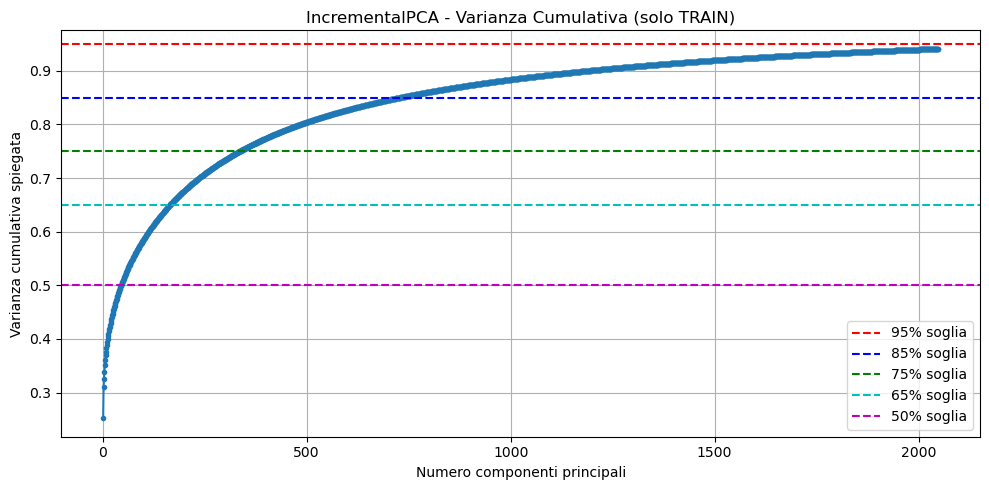

In [ ]:
# GRAFICO VARIANZA CUMULATIVA
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='.')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% soglia')
plt.axhline(y=0.85, color='b', linestyle='--', label='85% soglia')
plt.axhline(y=0.75, color='g', linestyle='--', label='75% soglia')
plt.axhline(y=0.65, color='c', linestyle='--', label='65% soglia')
plt.axhline(y=0.50, color='m', linestyle='--', label='50% soglia')
plt.xlabel('Numero componenti principali')
plt.ylabel('Varianza cumulativa spiegata')
plt.title('IncrementalPCA - Varianza Cumulativa (solo TRAIN)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

è molto strano che le componenti totali siano poco più di 30, quando abbiamo tante immagini (14.996) a colori e 224 x 224 
eseguiamo una serie di test per vedere se tutto funziona correttmente (cella 12) e vedere come comportarci successivamente

In [ ]:
# STAMPA NUM COMPONENTI PER SOGLIA
soglie = [0.95, 0.85, 0.75, 0.65, 0.50]
for soglia in soglie:
    num_components = np.argmax(cumulative_variance >= soglia) + 1
    print(f"Componenti che spiegano almeno il {int(soglia*100)}% della varianza: {num_components}")

Componenti che spiegano almeno il 95% della varianza: 1
Componenti che spiegano almeno il 85% della varianza: 728
Componenti che spiegano almeno il 75% della varianza: 336
Componenti che spiegano almeno il 65% della varianza: 165
Componenti che spiegano almeno il 50% della varianza: 45


In [ ]:
print(f"Numero immagini (n_samples): {train_data.shape[0]}")
print(f"Numero feature per immagine (n_features): {train_data.shape[1]}")
sample = next(iter(train_loader))[0]
print("Shape singola immagine:", sample[0].shape)  # dovresti avere (3, 224, 224)
print(f"Componenti totali calcolate: {len(ipca.explained_variance_ratio_)}")
print(train_data.shape)
print(ipca.n_components_)


Numero immagini (n_samples): 10497
Numero feature per immagine (n_features): 150528
Shape singola immagine: torch.Size([3, 224, 224])
Componenti totali calcolate: 2048
(10497, 150528)
2048


In [ ]:
# IMPORTANTE: con IncrementalPCA, il numero massimo di componenti principali calcolabili
# è limitato a n_components <= min(batch_size, n_features).
# 
# Nel nostro caso:
# - batch_size = 32
# - n_features = 150528 (immagini RGB 224x224 → 3*224*224)
# 
# Quindi il numero massimo di componenti principali che possono essere apprese per batch è 32.
# 
# Di conseguenza, anche se specifichiamo n_components = None (per calcolare tutte le possibili componenti),
# IncrementalPCA si ferma a 32 componenti, perché il batch ha solo 32 immagini.
#
# Per ottenere più componenti, è necessario aumentare il batch_size (es. 128 o 256),
# oppure usare PCA standard se la memoria lo consente.

# non si riesce a usare PCA -> torniamo a IPCA
# utilizziamo il batch maggiore che la RAM permette, calcoliamo la % di PC per ogni threshold
# per trovare le PC per ogni threshold su tutto il dataset faremo la media sulle precedenti

# passando da batch di 1024 a 2028 le PC sono diminuite, ma non di tanto 
# siamo passati da 739 a 728, eppure i dati su cui fare PCA sono raddoppiati, quindi
# le percentuali sono notevolmente diminuite, non ha senso guardare queste

# noto per 95% mi ese una sola PC, ma ciò non ha senso poichè per l'85% ne abbiamo 728

